# Prediction de la toxicité

## Prérequis

In [1]:
!python --version

Python 3.7.15


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
from pickle import load

import pandas as pd

from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw

## Chargement des données

In [4]:
# Récupération de l'identifiant uniprot
with open("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/01_compoundDataAcquisition/uniprot_id.txt", "rb") as file:
    uniprot_id = load(file)
print(uniprot_id)

P08581


In [9]:
# Importation du premier ensemble de données
firstMolecules = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/03_molecularSubstructureFiltering//"+uniprot_id+".csv")
print(f"shape first molecules : {firstMolecules.shape}")

# Importation du second ensemble de données
secondMolecules = pd.read_csv(f"/content/drive/MyDrive/Colab Notebooks/these_exercice/output/07_predictIC50/mol_pIC50sup9_{uniprot_id}.csv")
print(f"shape second molecules : {secondMolecules.shape}")


shape first molecules : (1308, 10)
shape second molecules : (89, 10)


In [16]:
# On ne garde que les colonnes jugées utiles
firstMolecules = firstMolecules.loc[:,["smiles","pIC50", "molecular_weight","n_hba","n_hbd","logp"]]
firstMolecules.head()

,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp
0,CNC(=O)c1ccc(-c2cnc3nnc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,413.140036,7,1,2.82400
1,CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,412.144787,6,1,3.42900
2,COc1ccc2c(OCc3nnc4ncc(-c5ccccc5)nn34)ccnc2c1,9.721246,384.133474,8,0,3.32210
3,Cc1c(O)ccc2nc(-c3cc(-c4cnn(C5CCNCC5)c4)cnc3N)o...,9.698970,504.173288,9,4,3.90732
4,CC(c1c(F)cc2ncc(-c3cnn(C)c3)cc2c1F)n1nnc2ncc(-...,9.522879,529.158641,9,1,3.96250


In [21]:
# On ne garde que les colonnes jugées utiles
secondMolecules = secondMolecules.loc[:,["smiles","predicted_pIC50", "molecular_weight","n_hba","n_hbd","logp"]]
secondMolecules.rename(columns = {"predicted_pIC50" : "pIC50"}, inplace = True)
secondMolecules.head()

,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp
0,CCCC1=C(C(=NC2=NC=NN12)CCC)CC3=CC=C(C=C3)C4=CC...,10.609104,438.228043,7.0,1.0,4.46720
1,CCCC1=C(C=NC2=NC=NN12)CC3=CC=C(C=C3)C4=CC=CC=C...,10.221253,396.181093,7.0,1.0,3.51470
2,C1=CC(=C1)C2=C(C(=O)N3C(=N2)N=CN3)CC4=CC(=C(C=...,10.152609,378.049523,4.0,1.0,3.63380
3,CC1=C(C(=NC2=NC=NN12)C)CC3=CC=C(C=C3)C4=CC=CC=...,10.036839,382.165443,7.0,1.0,3.17904
4,C1=CC(=C1)C2=C(C(=O)N3C(=N2)N=CN3)CC4=CC(=C(C=...,9.882215,328.052717,4.0,1.0,2.75410


In [24]:
# Fusion des jeux de données
molecules = pd.concat([firstMolecules, secondMolecules])
print(f"molecules : {molecules.shape}")

molecules : (1397, 6)


1397

## Création du fichier regroupant la formule SMILES et le nom/index

In [25]:
pd.DataFrame({'smiles' : molecules.smiles, 'index' : molecules.index}).to_csv(f"/content/drive/MyDrive/Colab Notebooks/these_exercice/input/09_predictToxicity/{uniprot_id}_moleculesToxStudy.smi", sep = "\t", header = False, index = False)

## Prédictions

In [26]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.5 MB 1.6 MB/s 


In [27]:
from os import chdir
chdir("/content/drive/MyDrive/Colab Notebooks/these_exercice/src/eToxPred")

In [28]:
!python "etoxpred_predict.py" --datafile "/content/drive/MyDrive/Colab Notebooks/these_exercice/input/09_predictToxicity/P08581_moleculesToxStudy.smi" --modelfile "/content/drive/MyDrive/Colab Notebooks/these_exercice/src/eToxPred/etoxpred_best_model.joblib" --outputfile "/content/drive/MyDrive/Colab Notebooks/these_exercice/output/09_predictToxicity/P08581_toxResults.csv"

...loading models
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator ExtraTreeClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator ExtraTreesClassifier from version 0.23.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,
...starts prediction
...prediction done!


## Chargement des prédictions et fusion du dataframe initial et prédictions

In [30]:
toxPrediction = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/these_exercice/output/09_predictToxicity/P08581_toxResults.csv")
toxPrediction.drop(["name"], axis = 1, inplace = True)
print(f"toxPrediction : {toxPrediction.shape}")
toxPrediction.head()

toxPrediction : (1397, 3)


,smiles,Tox-score,SAscore
0,CNC(=O)c1ccc(-c2cnc3nnc(Cc4ccc5ncccc5c4)n3n2)cc1F,0.506689,0.195202
1,CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)cc1F,0.514836,0.189067
2,COc1ccc2c(OCc3nnc4ncc(-c5ccccc5)nn34)ccnc2c1,0.546116,0.233918
3,Cc1c(O)ccc2nc(-c3cc(-c4cnn(C5CCNCC5)c4)cnc3N)o...,0.463750,0.120014
4,CC(c1c(F)cc2ncc(-c3cnn(C)c3)cc2c1F)n1nnc2ncc(-...,0.421857,0.065752


In [31]:
molecules = molecules.merge(toxPrediction, on="smiles")
molecules.head()

,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,Tox-score,SAscore
0,CNC(=O)c1ccc(-c2cnc3nnc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,413.140036,7.0,1.0,2.82400,0.506689,0.195202
1,CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,412.144787,6.0,1.0,3.42900,0.514836,0.189067
2,COc1ccc2c(OCc3nnc4ncc(-c5ccccc5)nn34)ccnc2c1,9.721246,384.133474,8.0,0.0,3.32210,0.546116,0.233918
3,Cc1c(O)ccc2nc(-c3cc(-c4cnn(C5CCNCC5)c4)cnc3N)o...,9.698970,504.173288,9.0,4.0,3.90732,0.463750,0.120014
4,CC(c1c(F)cc2ncc(-c3cnn(C)c3)cc2c1F)n1nnc2ncc(-...,9.522879,529.158641,9.0,1.0,3.96250,0.421857,0.065752


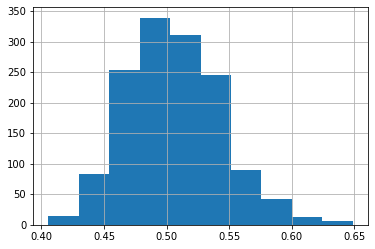

In [32]:
molecules.loc[:,"Tox-score"].hist()

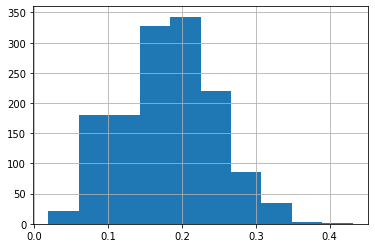

In [33]:
molecules.loc[:,"SAscore"].hist()

## Restriction aux molécules ayant la plus forte probabilité d'être non toxiques

D'après l'[étude de Pu et al.](https://doi-org.ressources-electroniques.univ-lille.fr/10.1186%2Fs40360-018-0282-6), une valeur de seuil de Tox-pred de 0.58 est la valeur la plus efficace pour disciminer les molécules toxiques des non-toxiques.

In [40]:
nonToxicMolecules = molecules[molecules.loc[:,"Tox-score"] < 0.58]
print(nonToxicMolecules.shape)
nonToxicMolecules.head()

(1344, 8)


,smiles,pIC50,molecular_weight,n_hba,n_hbd,logp,Tox-score,SAscore
0,CNC(=O)c1ccc(-c2cnc3nnc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,413.140036,7.0,1.0,2.82400,0.506689,0.195202
1,CNC(=O)c1ccc(-c2cnc3ncc(Cc4ccc5ncccc5c4)n3n2)cc1F,9.886057,412.144787,6.0,1.0,3.42900,0.514836,0.189067
2,COc1ccc2c(OCc3nnc4ncc(-c5ccccc5)nn34)ccnc2c1,9.721246,384.133474,8.0,0.0,3.32210,0.546116,0.233918
3,Cc1c(O)ccc2nc(-c3cc(-c4cnn(C5CCNCC5)c4)cnc3N)o...,9.698970,504.173288,9.0,4.0,3.90732,0.463750,0.120014
4,CC(c1c(F)cc2ncc(-c3cnn(C)c3)cc2c1F)n1nnc2ncc(-...,9.522879,529.158641,9.0,1.0,3.96250,0.421857,0.065752


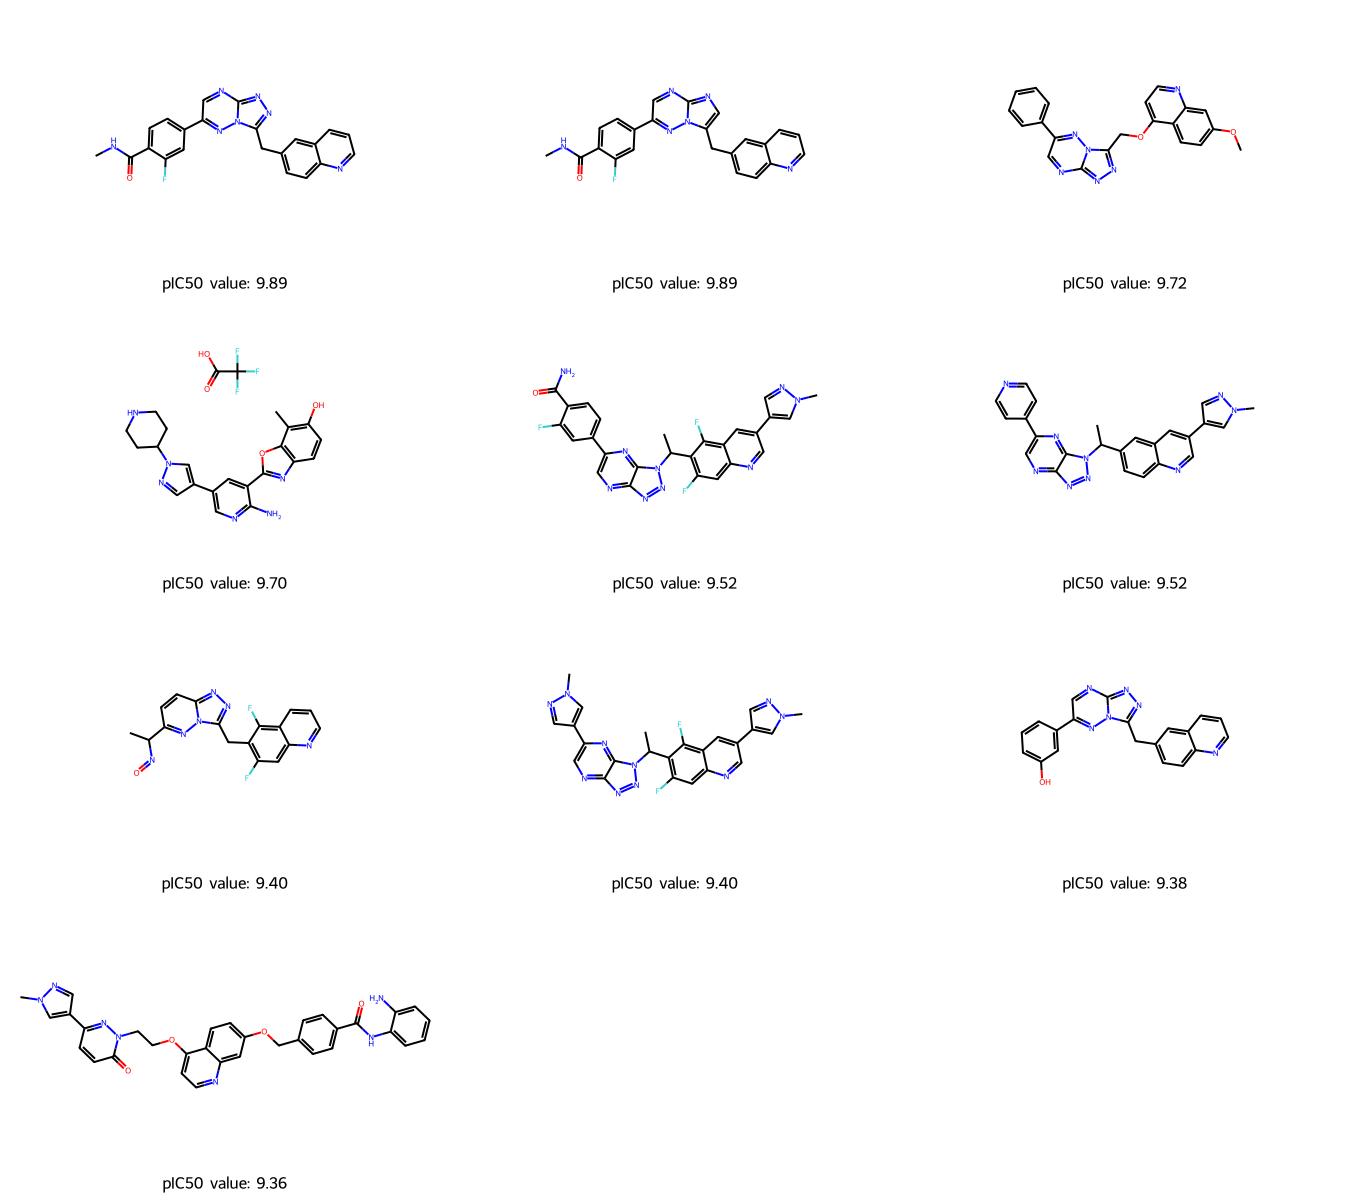

In [47]:
# Affichage des molécules

mols_protein = [Chem.MolFromSmiles(smile) for smile in nonToxicMolecules.smiles]
pIC50_protein = nonToxicMolecules["pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_protein]

Draw.MolsToGridImage(mols_protein[0:10], molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values[0:10])